### *01_data_exploration*

In [16]:
#  Import libraries and SSL settings
import ssl
import urllib3
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import networkx as nx
from pathlib import Path

ssl._create_default_https_context = ssl._create_unverified_context
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.filterwarnings('ignore')

#------------------------------------------------------------------data loading and key gene identifying 
# GitHub URLs
EXPRESSION_URL = "https://raw.githubusercontent.com/jaywang-cpu/-BDS-final-breast-cancer-immune-escape-gnn/refs/heads/main/data/expression_data.txt"
METADATA_URL = "https://raw.githubusercontent.com/jaywang-cpu/-BDS-final-breast-cancer-immune-escape-gnn/refs/heads/main/data/sample_metadata.csv"

# Loading gene expression data
expression_data = pd.read_csv(EXPRESSION_URL, sep='\t', index_col=0)
print(f"Gene expression data: {expression_data.shape[0]} genes × {expression_data.shape[1]} patients")
metadata = pd.read_csv(METADATA_URL)
print(f"Metadata: {metadata.shape}")

# Check key immune genes
key_genes = ['PDCD1', 'CD274', 'CD8A', 'IFNG']
available_genes = [gene for gene in key_genes if gene in expression_data.index]

print("Key immune genes check:")
for gene in key_genes:
    if gene in expression_data.index:
        expr_range = f"{expression_data.loc[gene].min():.1f}-{expression_data.loc[gene].max():.1f}"
        print(f"{gene}: {expr_range}")
    else:
        print(f"{gene}: Not found")

print(f"Available key genes: {len(available_genes)}/{len(key_genes)}")



#------------------------------------------------------------------data quality checking 
# Data quality checking 
print("\n Data Quality Check")

# 1. Basic completeness check
missing_count = expression_data.isnull().sum().sum()
negative_count = (expression_data < 0).sum().sum()
print(f"Missing values: {missing_count} | Negative values: {negative_count}")

# 2. RNA-seq characteristics check
zero_percentage = (expression_data == 0).sum().sum() / expression_data.size * 100
median_expr = expression_data.median().median()
mean_expr = expression_data.mean().mean()
print(f"Zero percentage: {zero_percentage:.1f}% | Median: {median_expr:.1f} | Mean: {mean_expr:.1f}")

# 3. Sample quality check
sample_totals = expression_data.sum(axis=0)
cv_total = sample_totals.std() / sample_totals.mean()
expressed_genes_per_sample = (expression_data > 0).sum(axis=0)
print(f"Sample CV: {cv_total:.3f} | Expressed genes per sample: {expressed_genes_per_sample.min()}-{expressed_genes_per_sample.max()}")

# 4. Key genes quality
key_genes = ['PDCD1', 'CD274', 'CD8A', 'IFNG']
print("\n Key genes quality:")
for gene in key_genes:
    if gene in expression_data.index:
        gene_expr = expression_data.loc[gene]
        cv = gene_expr.std() / gene_expr.mean() if gene_expr.mean() > 0 else 0
        zero_pct = (gene_expr == 0).sum() / len(gene_expr) * 100
        quality = "Good" if cv > 0.5 else "Fair" if cv > 0.3 else "Poor"
        print(f"   {gene}: CV={cv:.3f} | Zero={zero_pct:.1f}% | {quality}")

# 5. Sample correlation
sample_corr = expression_data.corr().mean().mean()
print(f"Average sample correlation: {sample_corr:.3f}")

# 6. Overall quality score
def quality_score():
    score = 0
    if missing_count == 0: score += 25
    if 20 <= zero_percentage <= 60: score += 25
    if cv_total < 0.5: score += 25
    if sample_corr > 0.6: score += 25
    return score

score = quality_score()
print(f"Data quality score: {score}/100")

if score >= 75:
    print("Excellent data quality")
elif score >= 50:
    print("Good data quality, can proceed")
else:
    print("Data quality needs improvement")





Gene expression data: 58387 genes × 24 patients
Metadata: (100064, 9)
Key immune genes check:
PDCD1: 0.0-231.7
CD274: 243.8-2168.4
CD8A: 70.9-1682.5
IFNG: 0.0-285.7
Available key genes: 4/4

 Data Quality Check
Missing values: 0 | Negative values: 0
Zero percentage: 46.6% | Median: 5.0 | Mean: 881.7
Sample CV: 0.122 | Expressed genes per sample: 19203-34423

 Key genes quality:
   PDCD1: CV=0.764 | Zero=4.2% | Good
   CD274: CV=0.624 | Zero=0.0% | Good
   CD8A: CV=0.750 | Zero=0.0% | Good
   IFNG: CV=0.873 | Zero=8.3% | Good
Average sample correlation: 0.908
Data quality score: 100/100
Excellent data quality


In [18]:
#------------------------------------------------------------------PDCD1 analysis and risk stratification
if 'PDCD1' in expression_data.index:
    pdcd1_expr = expression_data.loc['PDCD1']
    
    # PDCD1 detailed statistics
    print("PDCD1 Expression Statistics:")
    print(f"   Range: {pdcd1_expr.min():.2f} - {pdcd1_expr.max():.2f}")
    print(f"   Mean: {pdcd1_expr.mean():.2f}")
    print(f"   Median: {pdcd1_expr.median():.2f}")
    print(f"   Std Dev: {pdcd1_expr.std():.2f}")
    
    # Percentile analysis for risk stratification
    print(f"\nPDCD1 Expression Percentiles:")
    percentiles = [25, 50, 75, 80, 90, 95]
    for p in percentiles:
        value = np.percentile(pdcd1_expr, p)
        print(f"   {p:2d}th percentile: {value:7.2f}")
    
    # Create risk labels (80th percentile threshold)
    threshold_80 = np.percentile(pdcd1_expr, 80)
    risk_labels = (pdcd1_expr > threshold_80).astype(int)
    
    print(f"\nRisk Stratification (80th percentile = {threshold_80:.2f}):")
    high_risk_count = risk_labels.sum()
    low_risk_count = len(risk_labels) - high_risk_count
    print(f"   High-risk patients: {high_risk_count} ({high_risk_count/len(risk_labels)*100:.1f}%)")
    print(f"   Low-risk patients: {low_risk_count} ({low_risk_count/len(risk_labels)*100:.1f}%)")
    
    # Save risk labels for later use
    print("Risk labels created successfully!")
    
else:
    print("PDCD1 gene not found!")

PDCD1 Expression Statistics:
   Range: 0.00 - 231.71
   Mean: 83.00
   Median: 77.97
   Std Dev: 63.45

PDCD1 Expression Percentiles:
   25th percentile:   28.00
   50th percentile:   77.97
   75th percentile:  128.53
   80th percentile:  132.98
   90th percentile:  159.38
   95th percentile:  189.76

Risk Stratification (80th percentile = 132.98):
   High-risk patients: 5 (20.8%)
   Low-risk patients: 19 (79.2%)
Risk labels created successfully!


In [21]:
#------------------------------------------------------------------gene correlation analysis
print("Gene Correlation Analysis")

# Calculate correlations between key genes
print("Key Immune Genes Correlation:")
for i, gene1 in enumerate(available_genes):
    for j, gene2 in enumerate(available_genes):
        if i < j:  # Avoid duplicate pairs
            corr_coef, p_value = pearsonr(expression_data.loc[gene1], expression_data.loc[gene2])
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            print(f"   {gene1} - {gene2}: r = {corr_coef:.3f} {significance}")

# Correlation with PDCD1 specifically
print(f"\n Correlations with PDCD1 (PD-1):")
for gene in available_genes:
    if gene != 'PDCD1':
        corr_coef, p_value = pearsonr(pdcd1_expr, expression_data.loc[gene])
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        interpretation = "Strong" if abs(corr_coef) > 0.7 else "Moderate" if abs(corr_coef) > 0.4 else "Weak"
        print(f"   PDCD1 - {gene}: r = {corr_coef:.3f} {significance} ({interpretation})")


Gene Correlation Analysis
Key Immune Genes Correlation:
   PDCD1 - CD274: r = 0.467 *
   PDCD1 - CD8A: r = 0.713 ***
   PDCD1 - IFNG: r = 0.513 *
   CD274 - CD8A: r = 0.370 
   CD274 - IFNG: r = 0.354 
   CD8A - IFNG: r = 0.691 ***

 Correlations with PDCD1 (PD-1):
   PDCD1 - CD274: r = 0.467 * (Moderate)
   PDCD1 - CD8A: r = 0.713 *** (Strong)
   PDCD1 - IFNG: r = 0.513 * (Moderate)


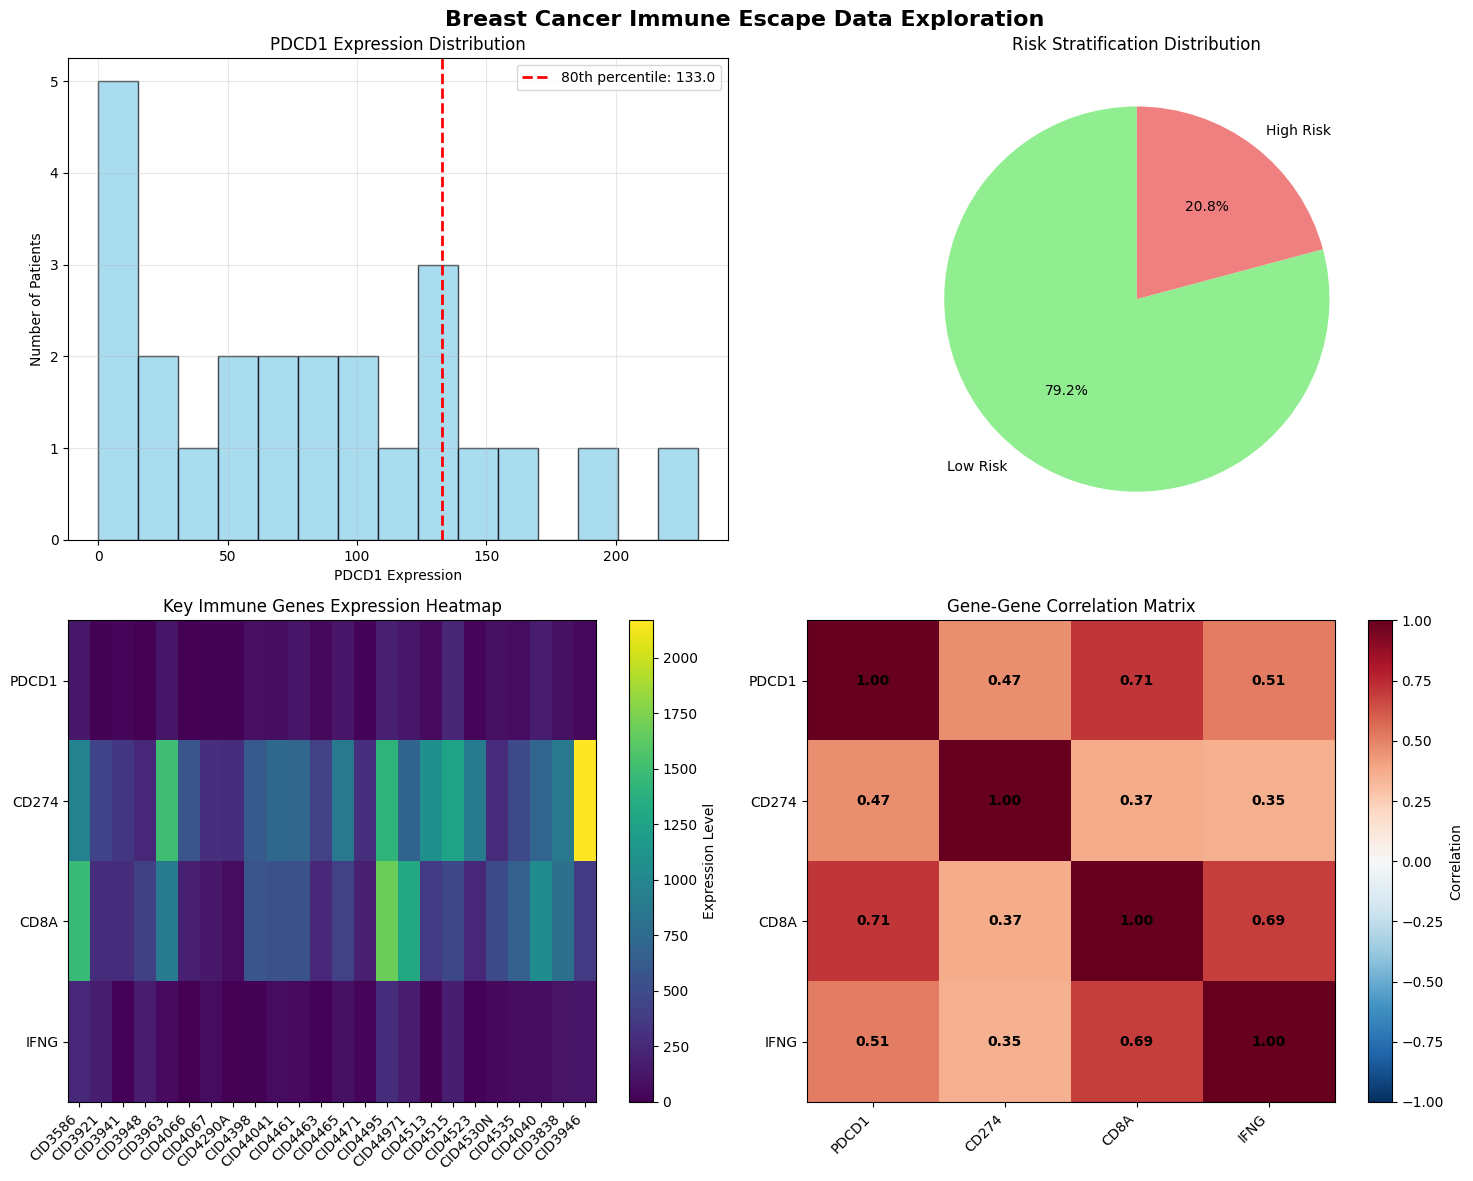

✅ Visualization completed!


In [ ]:
#------------------------------------------------------------------data visualization
# Set up plotting
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Breast Cancer Immune Escape Data Exploration', fontsize=16, fontweight='bold')

# 1. PDCD1 expression distribution
axes[0,0].hist(pdcd1_expr, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(threshold_80, color='red', linestyle='--', linewidth=2, label=f'80th percentile: {threshold_80:.1f}')
axes[0,0].set_xlabel('PDCD1 Expression')
axes[0,0].set_ylabel('Number of Patients')
axes[0,0].set_title('PDCD1 Expression Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Risk stratification visualization
risk_counts = [low_risk_count, high_risk_count]
risk_labels_text = ['Low Risk', 'High Risk']
colors = ['lightgreen', 'lightcoral']
axes[0,1].pie(risk_counts, labels=risk_labels_text, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Risk Stratification Distribution')

# 3. Key genes expression heatmap
key_genes_data = expression_data.loc[available_genes]
im = axes[1,0].imshow(key_genes_data.values, cmap='viridis', aspect='auto')
axes[1,0].set_xticks(range(len(expression_data.columns)))
axes[1,0].set_xticklabels(expression_data.columns, rotation=45, ha='right')
axes[1,0].set_yticks(range(len(available_genes)))
axes[1,0].set_yticklabels(available_genes)
axes[1,0].set_title('Key Immune Genes Expression Heatmap')
plt.colorbar(im, ax=axes[1,0], label='Expression Level')

# 4. Key genes correlation
key_genes_corr = key_genes_data.T.corr()
im2 = axes[1,1].imshow(key_genes_corr.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[1,1].set_xticks(range(len(available_genes)))
axes[1,1].set_xticklabels(available_genes, rotation=45, ha='right')
axes[1,1].set_yticks(range(len(available_genes)))
axes[1,1].set_yticklabels(available_genes)
axes[1,1].set_title('Gene-Gene Correlation Matrix')
plt.colorbar(im2, ax=axes[1,1], label='Correlation')

# Add correlation values to heatmap
for i in range(len(available_genes)):
    for j in range(len(available_genes)):
        text = axes[1,1].text(j, i, f'{key_genes_corr.iloc[i, j]:.2f}',
                             ha="center", va="center", color="black", fontweight='bold')

plt.tight_layout()
plt.show()
